## Handwritten Digit Generation with Variational Autoencoders

Generating handwritten digits (0-9) similar to the digits in the MNIST dataset with a VAE. 

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from models import VAE, VAELoss, ConvVAE

In [12]:
# Load and store the MNIST train data 
transform = transforms.Compose([
    torchvision.transforms.ToTensor(), 
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

batch_size = 200
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


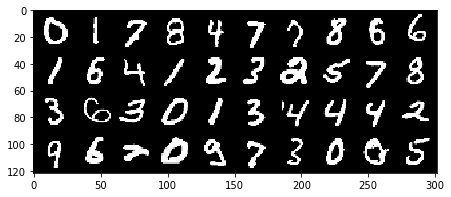

In [13]:
# Visualize some of the training data 
plt.figure(figsize=(15, 3))
digits, _ = next(iter(trainloader))
grid = torchvision.utils.make_grid(digits[0:40], nrow=10)
plt.imshow(grid.permute(1, 2, 0))
plt.show()

## VAE with Fully-Connected Layers

Smaller two hidden layer (for decoder and encoder each) neural network.  

We set up the VAE model, loss function, and optimizer and train the model with the training data. We flatten the dimension of the input images (?, 1, 28, 28) to a single dimension (?, 784) inside the model.

In [14]:
latent_size = 4 

# For model and loss function details see 'models.py' file. 
model = VAE(input_size=784, latent_size=latent_size).to(device)
criterion = VAELoss()
optimizer = optim.Adam(model.parameters(), lr=4e-4)

print(model)

VAE(
  (encoder_1): Linear(in_features=784, out_features=64, bias=True)
  (encoder_2): Linear(in_features=64, out_features=64, bias=True)
  (encoder_mu): Linear(in_features=64, out_features=4, bias=True)
  (encoder_logvar): Linear(in_features=64, out_features=4, bias=True)
  (decoder_1): Linear(in_features=4, out_features=64, bias=True)
  (decoder_2): Linear(in_features=64, out_features=64, bias=True)
  (decoder_3): Linear(in_features=64, out_features=784, bias=True)
)


In [15]:
# Training the model on the dataset
epochs = 25
for e in range(epochs):
    running_loss = 0
    for (_, data) in enumerate(trainloader, 0):
        x, _ = data
        x = x.to(device)

        optimizer.zero_grad()
        x, x_hat, mu, logvar, _ = model(x)
        loss = criterion(x, x_hat, mu, logvar)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {e}: Loss {running_loss / len(trainloader)}")

Epoch 0: Loss 102764.83203125
Epoch 1: Loss 76233.432890625
Epoch 2: Loss 70032.63114583334
Epoch 3: Loss 67489.91596354167
Epoch 4: Loss 65979.19536458333
Epoch 5: Loss 64702.6924609375
Epoch 6: Loss 63614.1837890625
Epoch 7: Loss 62666.32009114583
Epoch 8: Loss 61878.8790234375
Epoch 9: Loss 61163.0366796875
Epoch 10: Loss 60547.90795572917
Epoch 11: Loss 60007.347252604166
Epoch 12: Loss 59549.4059765625
Epoch 13: Loss 59146.103489583336
Epoch 14: Loss 58779.39997395833
Epoch 15: Loss 58460.538489583334
Epoch 16: Loss 58139.814609375
Epoch 17: Loss 57873.17231770833
Epoch 18: Loss 57599.7896875
Epoch 19: Loss 57380.946302083335
Epoch 20: Loss 57133.1615625
Epoch 21: Loss 56910.8267578125
Epoch 22: Loss 56714.736015625
Epoch 23: Loss 56515.977799479166
Epoch 24: Loss 56334.90609375


### Testing the Trained Fully-connected Model

We can create new samples by using the generator of the VAE. Inputs for the generator networks can be sampled as $z \sim \mathcal{N}(0, 1)$.

Model learns to generate digits, but the individual digits are not very pretty and easily differentiable from the real digits in most cases. The model also seems to depict the typical VAE characteristics and produces rather blurry images.  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


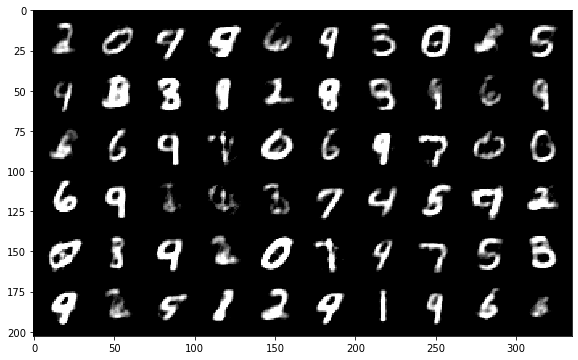

In [16]:
# setup some noise z for decoder network input.
z_test = np.random.normal(size=(60, latent_size))
z_test = torch.from_numpy(z_test).float().to(device)

x_hat = model.decode(z_test)
# reshape into old image format 
x_hat = x_hat.view((-1, 1, 28, 28))

# create and visualize grid
grid = torchvision.utils.make_grid(x_hat, nrow=10, padding=5)
plt.figure(figsize=(15, 6))
plt.imshow(grid.permute(1, 2, 0).detach().cpu().numpy())
plt.show()

## Deep Convolutional VAE 

Expanding the architecture of the model to use convolution and deconvolution operations to learn the probability distribution of the digits. 

The training procedure is (more or less) identical to the fully-connected version. 

In [17]:
latent_size = 6

# For model and loss function details see 'models.py' file. 
conv_model = ConvVAE(latent_size=latent_size).to(device)
criterion = VAELoss()
optimizer = optim.Adam(conv_model.parameters(), lr=4e-4)

print(conv_model)

ConvVAE(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
  (conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (encoder_fc_1): Linear(in_features=1600, out_features=512, bias=True)
  (encoder_mu): Linear(in_features=512, out_features=6, bias=True)
  (encoder_logvar): Linear(in_features=512, out_features=6, bias=True)
  (decoder_fc_1): Linear(in_features=6, out_features=512, bias=True)
  (decoder_fc_2): Linear(in_features=512, out_features=1600, bias=True)
  (deconv1): ConvTranspose2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (deconv2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1))
  (deconv3): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(1, 1))
)


In [18]:
for e in range(epochs):
    running_loss = 0
    for (_, data) in enumerate(trainloader, 0):
        x, _ = data
        x = x.to(device)

        optimizer.zero_grad()
        x, x_hat, mu, logvar, _ = conv_model(x)
        loss = criterion(x, x_hat, mu, logvar)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {e}: Loss {running_loss / len(trainloader)}")

Epoch 0: Loss 93260.56026041666
Epoch 1: Loss 67246.4396484375
Epoch 2: Loss 63397.25079427083
Epoch 3: Loss 61228.456328125
Epoch 4: Loss 59797.27427083333
Epoch 5: Loss 58739.849661458335
Epoch 6: Loss 57959.85239583333
Epoch 7: Loss 57301.136953125
Epoch 8: Loss 56769.549192708335
Epoch 9: Loss 56314.755703125
Epoch 10: Loss 55896.01640625
Epoch 11: Loss 55516.78373697917
Epoch 12: Loss 55228.755143229166
Epoch 13: Loss 54921.41661458334
Epoch 14: Loss 54681.74630208333
Epoch 15: Loss 54470.97015625
Epoch 16: Loss 54210.3037890625
Epoch 17: Loss 54008.19584635417
Epoch 18: Loss 53835.9998046875
Epoch 19: Loss 53657.695221354166
Epoch 20: Loss 53518.69046875
Epoch 21: Loss 53362.28962239583
Epoch 22: Loss 53215.217734375
Epoch 23: Loss 53101.09424479167
Epoch 24: Loss 52964.77072916667


### Testing the Trained Deep Convolutional VAE

Similar to the fully-connected version, generate noise $z \sim \mathcal{N}(0,I)$ as inpot for the decoder part of the model.

The results seem better and less blurry than the fully-connected model. Longer training time may still help produce better results.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


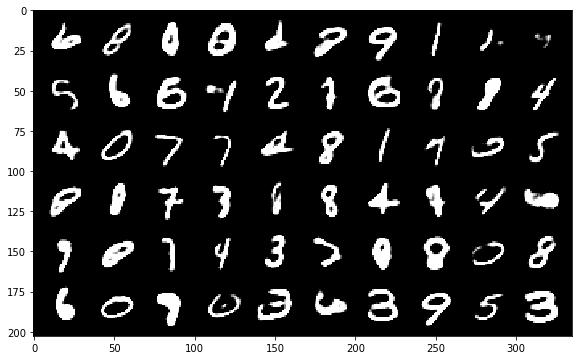

In [19]:
# setup z for decoder network input.
z_test = np.random.normal(size=(60, latent_size))
z_test = torch.from_numpy(z_test).float().to(device)

x_hat = conv_model.decode(z_test)
# reshape into old image format 
x_hat = x_hat.view((-1, 1, 28, 28))

# create and visualize grid
conv_grid = torchvision.utils.make_grid(x_hat, nrow=10, padding=5)
plt.figure(figsize=(15, 6))
plt.imshow(conv_grid.permute(1, 2, 0).detach().cpu().numpy())
plt.show()

## Comparison of the Results

Plotting the generated digits next to each other.

In [20]:
# Create new grid with smaller sizes
z_test = np.random.normal(size=(16, latent_size))
z_test = torch.from_numpy(z_test).float().to(device)

digits, _ = next(iter(trainloader))
data_grid = torchvision.utils.make_grid(digits[0:16], nrow=4, padding=5)
x_hat = model.decode(z_test)
x_hat = x_hat.view((-1, 1, 28, 28))
fc_grid = torchvision.utils.make_grid(x_hat, nrow=4, padding=5)
x_hat = conv_model.decode(z_test)
conv_grid = torchvision.utils.make_grid(x_hat, nrow=4, padding=5)

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(data_grid.permute(1, 2, 0).detach().cpu().numpy())
plt.axis('off')
plt.title('Training Data')

plt.subplot(132)
plt.imshow(fc_grid.permute(1, 2, 0).detach().cpu().numpy())
plt.axis('off')
plt.title('Fully-Connected Model')

plt.subplot(133)
plt.imshow(conv_grid.permute(1, 2, 0).detach().cpu().numpy())
plt.axis('off')
plt.title('Deep Conv. Model')
plt.show()

RuntimeError: size mismatch, m1: [16 x 6], m2: [4 x 64] at C:/w/1/s/windows/pytorch/aten/src\THC/generic/THCTensorMathBlas.cu:290